<a href="https://colab.research.google.com/github/dhcryan/dm_project/blob/main/scout_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data gathering & preprocessing**


### package import and download csv file

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import *
from scipy.spatial.distance import cdist
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics.pairwise as sim
from collections import OrderedDict
from PIL import Image
import requests
from bs4 import BeautifulSoup
import json
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [ ]:
!pip install ipywidgets
from ipywidgets import interact
import ipywidgets as widgets

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

drive mount

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


빅데이터를 처리하기 위한 pyspark 패키지 설치

In [6]:
import re
import sys
import itertools as it
from pyspark import SparkConf, SparkContext

In [7]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession 

spark 생성

In [8]:
spark=SparkSession.builder.appName('fifa').getOrCreate()

In [9]:
# # The applied options are for CSV files. For other file types, these will be ignored.
df=spark.read.option("inferSchema", "true").option("header", "true").csv('/content/drive/MyDrive/players_fifa23.csv')
df.show(10) 

+--------+-----------------------+------------------------------------+----+-------+-------+-------------------------------------------------+-------------------------+--------+----------+-------+-----------+----------+--------------+-------------+--------------------------------------+----------+--------+--------------+-------------+--------------+-----------+-----------+-------+--------------------+-----------------+---------------+--------------+--------------+---------+-----------+------------------+------------------+----------+--------------+-------------+---------------+---------------+-----------------+---------+----------+----------------+-------------+--------+----------+------+-----------+------------+------------+-------------+------------+--------+----------+--------+----------+--------+--------+---------+----------+-----------+--------------+------------+-------+----------+----------+--------+---------------+--------------+---------+-----------+----------+--------------+-

dataframe의 column명에 공백이 있을 경우 문제가 되기에 지워준다.

In [ ]:
from pyspark.sql.functions import *
#strip header space
for each in df.schema.names:
    df = df.withColumnRenamed(each,re.sub(r'\s+([a-zA-Z_][a-zA-Z_0-9]*)\s*','',each.replace(' ', '')))
# df.show(10)

column의 데이터도 trim하여 공백을 없앤다.

In [ ]:

for c_name in df.columns:
    if c_name in ['Name','FullName','PhotoUrl','Nationality','Positions','BestPosition','ClubPosition','ContractUntil','ClubNumber','OnLoad','NationalTeam','NationalPosition','NationalNumber','PreferredFoot','AttackingWorkRate','DefensiveWorkRate']:
      df = df.withColumn(c_name, trim(col(c_name)))
# df.show()

### missing value analysis


missing value가 있으면 데이터 관련 연산에 있어서 문제가 생길 수 있기에 찾아내야 함

*그러나 **missing value 없음**(과거 fifa dataset에 비해 데이터가 잘 정제되어 있음)*

In [12]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
missing_df = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
# missing_df.show()
# ClubPosition|ContractUntil|ClubNumber 92개의 missing value -> 자유계약이어서 소속팀이 현재 없는 선수라 삭제 안해도됨
# NationalPosition|NationalNumber -> 국대 아닌 선수들 17722
# 그 외의 결측치 없음

+---+----+--------+---+------+------+--------+-----------+-------+---------+------+----------+---------+---------+------------+----+--------+-------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+--------+--------+
| ID|Name|FullName|Age|Height|Weight|PhotoUrl|Natio

In [13]:
from pyspark.sql.types import IntegerType
df=df.withColumn("ID",df["ID"].cast(IntegerType()))
df=df.withColumn("Age",df["Age"].cast(IntegerType()))
df=df.withColumn("Overall",df["Overall"].cast(IntegerType()))
df=df.withColumn("Potential",df["Potential"].cast(IntegerType()))
df=df.withColumn("IntReputation",df["IntReputation"].cast(IntegerType()))
df=df.withColumn("SkillMoves",df["SkillMoves"].cast(IntegerType()))
df=df.withColumn("WeakFoot",df["WeakFoot"].cast(IntegerType()))
df=df.withColumn("Height",df["Height"].cast(IntegerType()))
df=df.withColumn("Weight",df["Weight"].cast(IntegerType()))


In [ ]:
# df.printSchema()

### spark 데이터를 pandas 로 변환

In [15]:
print(df.show())

+------+-----------------+--------------------+---+------+------+--------------------+--------------+-------+---------+------+----------+---------+---------+------------+--------------------+--------+--------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+--------+-

In [ ]:
Fifa_df = df.toPandas()
# Fifa_df.info()

### 골키퍼를 제외한 필드 플레이어 데이터 분류 및 index 정리



In [258]:
#gk와 non gk구분 
def segment_gk(Fifa_df):
  gk_data=Fifa_df[Fifa_df.BestPosition=='GK']
  nongk_data=Fifa_df[Fifa_df.BestPosition!='GK']
  return gk_data,nongk_data
gk,non_gk=segment_gk(Fifa_df)

In [259]:
# attrs=['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve'\
#        ,'FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions'\
#        ,'Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions'\
#        ,'Positioning','Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle'\
#        ,'GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']
def cluster_attrs(nongk):    
    attrs_groups = dict()
    attrs_groups['passing'] = ['Crossing','ShortPassing','FKAccuracy','LongPassing','Vision'] # passing 관련 index
    attrs_groups['shooting'] = ['Finishing','LongShots','Penalties','ShotPower','Volleys','Curve'] # shooting 관련 index
    attrs_groups['pace'] = ['Acceleration','SprintSpeed'] # 속도 관련 index
    attrs_groups['skill'] = ['BallControl','Dribbling'] # skill 관련 index
    attrs_groups['movement']=['Agility','Reactions','Positioning','Composure'] # 움직임 관련 index
    attrs_groups['defending'] = ['Interceptions','Marking','StandingTackle','SlidingTackle'] # 수비 관련 index
    attrs_groups['physicality'] = ['Aggression','Stamina','Strength','Balance','Jumping','HeadingAccuracy'] # physical 관련 index
    #attrs_groups['goalkeeping'] = ['GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes']
    pass_index=nongk[attrs_groups['passing']].mean(axis=1)
    shoot_index=nongk[attrs_groups['shooting']].mean(axis=1)
    pace_index=nongk[attrs_groups['pace']].mean(axis=1)
    skill_index=nongk[attrs_groups['skill']].mean(axis=1)
    movement_index=nongk[attrs_groups['movement']].mean(axis=1)
    defense_index=nongk[attrs_groups['defending']].mean(axis=1)
    pysical_index=nongk[attrs_groups['physicality']].mean(axis=1)
    
    index_concat=pd.concat([pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index],axis=1,ignore_index=True)
    #radar chart만들기 위해 normalize해야 할 필요성 있음
    nongk_value = index_concat.values #returns a numpy array
    scaler = preprocessing.StandardScaler() # 데이터 표준화 한다.
    nongk_scaled=scaler.fit_transform(nongk_value)
    return nongk_scaled.round(2)

In [260]:
nongk_scaled=cluster_attrs(non_gk)
nongk_df= pd.DataFrame(nongk_scaled)
nongk_df.columns=['pass_index','shoot_index','pace_index','skill_index','movement_index','defense_index','physical_index']

코드 실행 후 아래와 같이 표준화된 결과를 얻을 수 있다. 

In [261]:
nongk_df.head(7)

pass_index  shoot_index  pace_index  skill_index  movement_index  \
0        3.43         2.80        1.20         3.15            3.67   
1        2.45         2.67        1.02         2.65            3.09   
2        2.24         2.85        0.65         2.45            3.09   
3        3.52         2.80        0.56         2.65            2.86   
4        2.14         2.58        2.62         2.95            3.49   
5        2.31         2.70        1.98         2.65            3.52   
6        2.22         2.93        1.15         2.40            3.35   

   defense_index  physical_index  
0          -1.22            0.77  
1          -1.15            2.02  
2          -0.85            2.82  
3           0.67            1.20  
4          -1.07            1.76  
5          -0.40            1.45  
6          -1.36            2.02

### Web scraping from Understat.com and find team with problems






#### Web scraping

Let's start web scraping!

기대 득점(xG)은 팀과 선수의 성과를 평가할 수 있는 새로운 혁명적인 축구 지표이다.

scripts에서 teamsData 변수에 각 팀들에 대한 정보가 담겨져 있다.

In [21]:
url='https://understat.com/league/EPL/2022'
res=requests.get(url)
soup=BeautifulSoup(res.content,"lxml")
# JSON 분석해보니까 script태그 쓴다.
scripts = soup.find_all('script')

In [22]:
json_data=''
for elem in scripts:
  if 'teamsData' in str(elem):
    json_data=str(elem).strip()
index_start= json_data.index("('")+2
index_end= json_data.index("')")
json_data = json_data[index_start:index_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data=json.loads(json_data)

columns 추출

In [23]:
columns=[]
for id in data.keys():
  columns=list(data[id]['history'][0].keys())
columns

['h_a',
 'xG',
 'xGA',
 'npxG',
 'npxGA',
 'ppda',
 'ppda_allowed',
 'deep',
 'deep_allowed',
 'scored',
 'missed',
 'xpts',
 'result',
 'date',
 'wins',
 'draws',
 'loses',
 'pts',
 'npxGD']

각 팀 이름 추출

In [24]:
# Get teams and their relevant ids and put them into separate 
epl_teams={}
for id in data.keys():
  epl_teams[id]=data[id]['title']
# epl_teams

In [25]:
# data[id]['history']

key가 team name이고 각 팀들의 경기 데이터가 담긴 dictionary기반의 dataframe이 생긴다.

In [ ]:
tables={}
for id,team in epl_teams.items():
  team_data=[]
  #경기들의 데이터 모두 append
  for row in data[id]['history']:
    team_data.append(list(row.values()))
  df=pd.DataFrame(team_data,columns=columns)
  tables[team]=df #team이 key, df가 value
# tables
tables

ppda와 ppda_allowed가 dict형태로 나타남


*   PPDA: 압박 강도(우리 팀)
*   PPDA_allowd: 압박 강도(상대 팀)



`{'att': 464, 'def': 10}	{'att': 147, 'def': 23}`

In [27]:
for team,df in tables.items():
  tables[team]['ppda']=tables[team]['ppda'].apply(lambda x:x['att']/x['def'] if x['def']!=0 else 0)
  tables[team]['ppda_allowed']=tables[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)

합계를 통해 데이터를 구해야 하는 데이터와 평균으로 구해야 하는 데이터가 있음

In [28]:
columns_tosum=['h_a',
 'xG',
 'xGA',
 'npxG',
 'npxGA',
 'deep',
 'deep_allowed',
 'scored',
 'missed',
 'xpts',
 'result',
 'date',
 'wins',
 'draws',
 'loses',
 'pts',
 'npxGD']
 
columns_tomean=['ppda',
 'ppda_allowed']

경기별로 나누어져 있던 통계를 연산을 통해 구단별로 feature별 한 가지 값만 갖도록 한다.

EPL_df는 리그 순위별로 각 팀들의 정보를 알려주는 dataframe이다.

In [29]:
final_df=[]
for team, df in tables.items():
  sum_data = pd.DataFrame(df[columns_tosum].sum()).transpose()
  mean_data = pd.DataFrame(df[columns_tomean].mean()).transpose()
  team_df = pd.concat([sum_data,mean_data],axis=1)
  team_df['team'] = team
  team_df['matches'] = len(df)
  final_df.append(team_df) # 하나에 몽땅
final_df=pd.concat(final_df)

final_df['xG_diff']=final_df['xG']-final_df['scored']
final_df['xGA_diff']=final_df['xGA']-final_df['missed']
final_df['xpts_diff']=final_df['xpts']-final_df['pts']
final_df.sort_values('pts', ascending=False, inplace=True)
final_df['position'] = range(1,len(final_df)+1)
col_order = ['position', 'team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'xG_diff', 'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda',
 'ppda_allowed', 'deep', 'deep_allowed', 'xpts', 'xpts_diff']
EPL_df=final_df[col_order].set_index('position')
EPL_df

team  matches wins draws loses scored missed pts  \
position                                                                        
1                         Arsenal       11    9     1     1     25     11  28   
2                 Manchester City       11    8     2     1     36     11  26   
3                       Tottenham       12    7     2     3     23     14  23   
4                Newcastle United       12    5     6     1     20     10  21   
5                         Chelsea       11    6     3     2     16     11  21   
6               Manchester United       11    6     2     3     16     16  20   
7                          Fulham       12    5     3     4     22     22  18   
8                       Liverpool       11    4     4     3     22     13  16   
9                        Brighton       11    4     3     4     15     14  15   
10                      Brentford       12    3     5     4     18     21  14   
11                       West Ham       12    4     2     6     11     12  14   
12                    Bournemouth       12    3     4     5     10     25  13   
13                 Crystal Palace       11    3     4     4     12     16  13   
14                        Everton       12    3     4     5     11     12  13   
15                    Aston Villa       12    3     3     6     11     16  12   
16                    Southampton       12    3     3     6     11     19  12   
17                      Leicester       12    3     2     7     21     24  11   
18        Wolverhampton Wanderers       12    2     3     7      5     18   9   
19                          Leeds       11    2     3     6     13     18   9   
20              Nottingham Forest       12    2     3     7      8     23   9   

                 xG   xG_diff  ...        xGA  xGA_diff      npxGA      npxGD  \
position                       ...                                              
1         21.878527 -3.121473  ...  10.813533 -0.186467   9.291189  11.826168   
2         26.040643 -9.959357  ...   8.337277 -2.662723   7.576103   16.94221   
3         19.494882 -3.505118  ...  13.995138 -0.004862  13.233974   3.977394   
4         21.456988  1.456988  ...  15.169716  5.169716  14.408549   6.287266   
5          15.09848  -0.90152  ...  15.246417  4.246417  15.246417  -1.670281   
6         16.203223  0.203223  ...  14.062206 -1.937794  13.301032   2.141017   
7         17.201832 -4.798168  ...  25.643862  3.643862  24.121518  -9.964367   
8         23.461821  1.461821  ...   18.23173   5.23173  15.948217   7.513604   
9         19.311405  4.311405  ...   12.54567  -1.45433   11.02334   6.004551   
10        17.646957 -0.353043  ...  19.173989 -1.826011  18.412819  -3.049349   
11        17.680382  6.680382  ...  13.139861  1.139861  11.617531   3.018171   
12          8.42486  -1.57514  ...  20.220245 -4.779755  17.175557  -8.750697   
13        12.114309  0.114309  ...  17.471821  1.471821  17.471821  -6.262262   
14        12.887683  1.887683  ...  18.890283  6.890283  17.367943   -4.48026   
15        15.351162  4.351162  ...  15.801834 -0.198166  14.135914   0.454078   
16        11.710238  0.710238  ...   17.98126  -1.01874   17.98126  -6.271022   
17        11.673498 -9.326502  ...  18.279915 -5.720085  17.518745  -6.606411   
18        11.862817  6.862817  ...   15.33473  -2.66527  13.812399   -2.71075   
19        15.631136  2.631136  ...  16.233508 -1.766492  15.472348  -0.602382   
20          12.7886    4.7886  ...  21.346448 -1.653552   19.06294  -7.796678   

               ppda  ppda_allowed  deep deep_allowed     xpts xpts_diff  
position                                                                 
1         10.247982     14.504708   130           47  22.7013   -5.2987  
2         12.770973     31.106013   142           35  26.6627    0.6627  
3         14.070758     16.450994    86           98  20.0519   -2.9481  
4         10.207377     13.099846   132           80  19.8757   -1.1243  
5          9.173452

#### xG & xGA difference

xG_diff : xG와 실제 득점 수의 차이, 이 값이 양의 방향으로 클수록 기대 득점에 비해 골을 넣지 못했으며 팀의 골결정력이 낮다고 볼 수 있다.

xGA_diff : xGA와 실제 실점 수의 차이, 이 값이 음의 방향으로 클수록 기대 실점에 비해 더 많은 실점을 기록했으며 팀의 수비력이 좋지 않다고 볼 수 있다.

xpts_diff: xpts와 실제 승점간의 차이, 이 값이 양의 방향으로 클수록 기대 승점에 비해 승점을 쌓지 못했다고 볼 수 있다.

xG_diff>EPL_df['xG_diff'].mean(), xGA_diff<EPL_df['xGA_diff'].mean(), xpts_diff>EPL_df['xpts_diff'].mean() 세 조건 모두 해당되는 팀은 하위권일 확률이 높다.

In [30]:
EPL_df.loc[(EPL_df['xG_diff']>EPL_df['xG_diff'].mean()) & (EPL_df['xGA_diff']<EPL_df['xGA_diff'].mean())&(EPL_df['xpts_diff']>EPL_df['xpts_diff'].mean()),['team','scored','missed','pts','xG_diff','xGA_diff','xpts_diff']]

team scored missed pts   xG_diff  xGA_diff  \
position                                                                  
9                        Brighton     15     14  15  4.311405  -1.45433   
15                    Aston Villa     11     16  12  4.351162 -0.198166   
16                    Southampton     11     19  12  0.710238  -1.01874   
18        Wolverhampton Wanderers      5     18   9  6.862817  -2.66527   
19                          Leeds     13     18   9  2.631136 -1.766492   
20              Nottingham Forest      8     23   9    4.7886 -1.653552   

         xpts_diff  
position            
9           5.1751  
15          5.2028  
16           0.216  
18          4.6549  
19          5.8684  
20          2.3579

xG & xGA difference 를 통해 알아보는 강등권 팀 지표

0.09597213499999997 0.09597213499999961


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


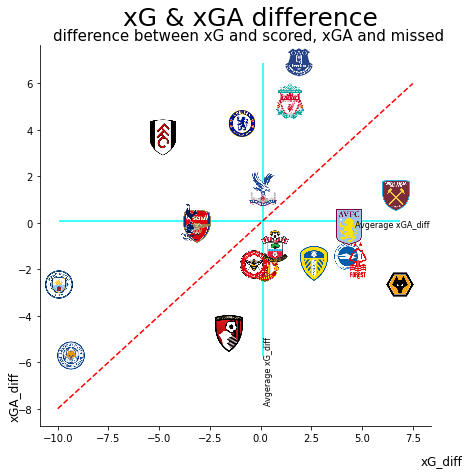

In [31]:
xg_selected= ['team','xG', 'xG_diff','xGA', 'xGA_diff','xpts', 'xpts_diff']
xg_df=EPL_df[xg_selected]
print(xg_df['xGA_diff'].mean(),xg_df['xG_diff'].mean())
xg_df['path']=xg_df['team']+'.png'
fig,ax=plt.subplots(figsize=(7,7))
plt.plot([-10,7.5],[-8,6],'r--')
# # plot spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.scatter(xg_df['xG_diff'],xg_df['xGA_diff'],color='w')

for index, row in xg_df.iterrows():
    logo=OffsetImage(plt.imread('/content/drive/MyDrive/GB1/' +row['path']), zoom=.20, alpha = 1)
    ab = AnnotationBbox(logo, (row['xG_diff'], row['xGA_diff']),frameon=False)
    ax.add_artist(ab)
# 평균 라인 추가
plt.hlines(xg_df['xGA_diff'].mean(), xg_df['xG_diff'].min(),xg_df['xG_diff'].max(), color='aqua')
plt.vlines(xg_df['xG_diff'].mean(),xg_df['xGA_diff'].min(),xg_df['xGA_diff'].max(), color='aqua')

fig.text(.29,.92,'xG & xGA difference',size=25)
fig.text(.15,.89,'difference between xG and scored, xGA and missed',size=15)

fig.text(.06,.14,'xGA_diff',size=12,rotation=90)
fig.text(.88,0.05,'xG_diff',size=12)

fig.text(.75,.52,'Avgerage xGA_diff',size=8)
fig.text(.57,.17,'Avgerage xG_diff', size=8,rotation=90)
plt.show()

이번엔 선수 데이터를 scraping한 후 울버햄튼 선수들의 통계자료를 조회해보았다.

공수 양면에서 처참한 지표를 확인할 수 있다.

그렇다면 이들을 위한 선수 추천 시스템을 구축해보자

In [32]:
# epl 선수 데이터
link = "https://understat.com/league/EPL"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# player 데이터 가져오기
strings = scripts[3].string 

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
# 데이터프레임 생성 
df = pd.DataFrame(data)
wolves=df.loc[(df['team_title']=='Wolverhampton Wanderers'),:]
wolves.sort_values('xG', ascending=False, inplace=True)
wolves

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


id      player_name games  time goals                    xG assists  \
61    8291   Daniel Podence    12   865     2     2.009035561233759       0   
58    6853      Rúben Neves    11   990     2    1.3409418696537614       0   
196    802      Diego Costa     5   331     0     1.132934883236885       0   
444  11000    Matheus Nunes    10   824     0    1.0751876384019852       1   
250   4105     Raúl Jiménez     3   209     0     0.821384608745575       0   
291   6382       Pedro Neto     8   616     0     0.759812081232667       0   
89     900     Adama Traoré     9   424     1    0.5782075375318527       0   
268   5682   Gonçalo Guedes     9   530     0    0.5584308281540871       1   
368   8812   Sasa Kalajdzic     1    48     0    0.5194778442382812       0   
248   3422    João Moutinho    10   793     0    0.5037771593779325       0   
327   7332       Max Kilman    12  1080     0   0.49601571913808584       0   
301   6674  Rayan Ait Nouri     9   649     0    0.3170508146286011       0   
371   8845   Hee-Chan Hwang    10   238     0   0.27225046046078205       1   
237   2280            Jonny    11   943     0    0.1815946940332651       0   
425  10755     Joseph Hodge     3    70     0   0.09458642452955246       0   
403   9741    Chem Campbell     5    55     0   0.06225842051208019       0   
409  10140       Hugo Bueno     3   181     0   0.02514027990400791       1   
285   6163    Nélson Semedo    10   469     0  0.021319009363651276       0   
352   8119  Boubacar Traore     5   107     0                     0       0   
400   9733   Nathan Collins     9   752     0                     0       0   
402   9740          José Sá    12  1080     0                     0       0   
412  10293             Toti     2   180     0                     0       0   

                      xA shots key_passes yellow_cards red_cards position  \
61    1.4737432450056076    20         19            2         0    F M S   
58   0.34978197142481804    19          7            5         0      D M   
196  0.14054637774825096    12          2            0         0      F S   
444   1.1658550798892975    14         11            1         0        M   
250   0.4429885149002075     7          2            0         0      F S   
291   1.3859161753207445    11         13            1         0    D F M   
89    0.5705661103129387     6          8            0         0      M S   
268   0.5178038626909256    12          8            1         0    F M S   
368                    0     1          0            0         0        F   
248    1.260036837309599     8         18            2         0      M S   
327                    0     5          0            0         0        D   
301   0.6398963406682014     6          6            1         0      D S   
371   0.5283135771751404     5          2            0         0      F S   
237  0.09889318235218525     8          2            2         0        D   
425                    0     1          0            1         0        S   
403                    0     2          0            0         0        S   
409  0.36497440189123154     1          3            0         0      D S   
285  0.10028801672160625     1          4            2         0      D S   
352                    0     0          0            1         0      M S   
400  0.07463285326957703     0          2            1         1        D   
402                    0     0          0            0         0       GK   
412  0.03923457860946655     0          1            0         0        D   

                  team_title npg                  npxG              xGChain  \
61   Wolverhampton Wanderers   2     2.009035561233759    4.941349893808365   
58   Wolverhampton Wanderers   1    0.5797730507329106    4.260968659073114   
196  Wolverhampton Wanderers   0     1.132934883236885   0.9866080433130264   
444  Wolverhampton Wanderers   0    1.0751876384019852    2.735894575715065   
250  Wolverhampton Wand

## **Problem and Solution Approach**

### PCA(주성분 분석)

pca를 하기 전에 standardazation을 통해 scaling된 데이터를 활용한다. 

scaling을 하지 않을 경우에 분산량이 왜곡될수 있으니 필수적으로 해야 한다.

그 후 주성분 분석 과정에서 공분산 행렬을 통해 eigenvalue와 eigenvector를 구할 수 있고 주성분 각각의 설명 가능한 분산량(=eigenvalue)이 출력된다.

In [262]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(nongk_scaled)
evr = pca.explained_variance_ratio_
print(evr)

[0.53406225 0.2333198  0.10916886 0.07671527 0.02135    0.01443702
 0.01094679]


아래의 그래프는 주성분 각각의 eigenvalue를  eigenvalue를 모두 더한 값으로 나눠 준 것이다.
이를 통해 해당 주성분의 고윳값이 차지하는 비율을 알 수 있다.

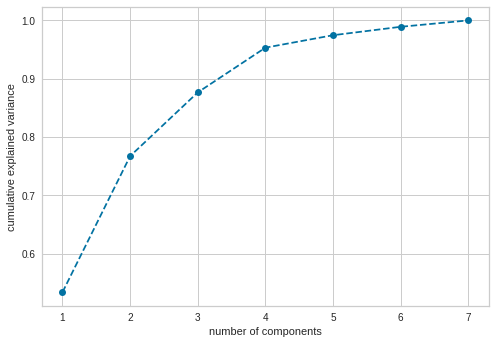

In [263]:
plt.plot(range(1,len(nongk_df.columns)+1),np.cumsum(evr),marker='o',linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

원래 dimension이 7이었는데
위 소스 코드의 핵심은 PCA의 파라미터 주성분 개수(n_components)를 결정하여 개수에 맞는 원래 데이터에서 변환된 주성분을 추출하는 것이다. 본 글에서는 주성분을 4개로 결정하였다. 

4개의 주성분을 통해 전체 분산의 95퍼 이상 설명 가능

In [264]:
for i, exp_var in enumerate(evr.cumsum()):
  print(i+1,"번째 분산량",evr[i], '\t','누적 분산량: ',exp_var)
  if exp_var >= 0.95:
      n_comps = i + 1
      break
print("Number of components:", n_comps)
# print(sum(evr,[]))
print(pca.explained_variance_ratio_)
pca = PCA(n_components=n_comps)
pca.fit(nongk_scaled)
nongk_scaled_pca = pca.transform(nongk_scaled)

1 번째 분산량 0.5340622533591339 	 누적 분산량:  0.5340622533591339
2 번째 분산량 0.23331979918533788 	 누적 분산량:  0.7673820525444718
3 번째 분산량 0.10916885512772596 	 누적 분산량:  0.8765509076721978
4 번째 분산량 0.07671527456626721 	 누적 분산량:  0.953266182238465
Number of components: 4
[0.53406225 0.2333198  0.10916886 0.07671527 0.02135    0.01443702
 0.01094679]


### K-Means clustering(K 평균 클러스터링)

#### Elbow Method를 통해 적합한 k 값 찾기

The kneed KneeLocator와 클러스터 내의 총 변동을 설명하는 WCSS(Within Clusters Sum of Squares)를 이용하여 elbow point를 찾는다.

In [265]:
!pip install kneed
# Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데
# 이 지점의 K 값을 군집의 개수로 사용
# inertia_ 속성으로 확인할 수 있다.
# 클러스터 간 거리의 합을 나타내는 inertia value가 급격히 떨어지는 구간 이용
from kneed import KneeLocator
inertia_arr=[]
def elbow_point_for_k(nongk_scaled_pca):
  global inertia_arr
  k_range=range(2,15)
  for k in k_range:
    kmeans_pca=KMeans(n_clusters=k).fit(nongk_scaled_pca)
    inertia=kmeans_pca.inertia_
    inertia_arr.append(inertia)
    print('k value: ',k,'\t','cost: ',inertia)
  n_clusters = KneeLocator([i for i in k_range], inertia_arr, curve='convex', direction='decreasing').knee
  print("Optimal number of clusters", n_clusters)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [266]:
elbow_point_for_k(nongk_scaled_pca)

k value:  2 	 cost:  70202.55628275833
k value:  3 	 cost:  55469.04987744601
k value:  4 	 cost:  46321.81822848176
k value:  5 	 cost:  41051.20216906294
k value:  6 	 cost:  37754.37797819103
k value:  7 	 cost:  34910.2086666341
k value:  8 	 cost:  32448.129437924712
k value:  9 	 cost:  30244.29636290933
k value:  10 	 cost:  28484.707899863788
k value:  11 	 cost:  27020.20732861955
k value:  12 	 cost:  25786.886017293524
k value:  13 	 cost:  24710.174579336133
k value:  14 	 cost:  23687.07652016099
Optimal number of clusters 5


Text(0, 0.5, 'Average within-cluster sum-of-squares(inertia)')

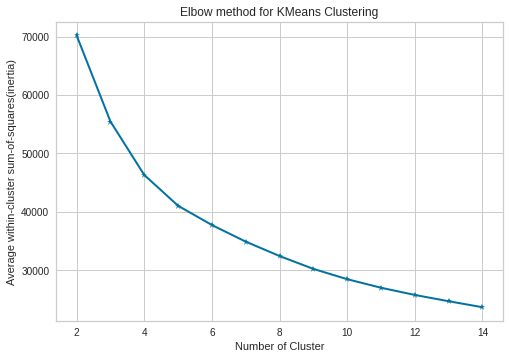

In [267]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(range(2,15),inertia_arr,'b*-',linewidth=2)
plt.grid(True)
plt.title('Elbow method for KMeans Clustering')
plt.xlabel('Number of Cluster')
plt.ylabel('Average within-cluster sum-of-squares(inertia)')

KElbowVisualizer를 활용하여 k값 한번에 구해주기

In [268]:
from yellowbrick.cluster import KElbowVisualizer

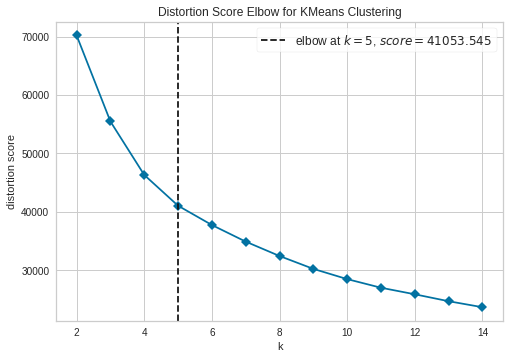

최적의 k값 5


In [269]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(2,15), timings=False)
visualizer.fit(nongk_scaled_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("최적의 k값", n_clusters)

k=5에 맞춰 군집화

In [270]:
number_of_clusters = 5
kmeanModel = KMeans(n_clusters = number_of_clusters ) 
kmeanModel.fit(nongk_scaled_pca)

KMeans(n_clusters=5)

In [271]:
labels=kmeanModel.labels_

기존 nongk_df에 nongk_scaled_pca(pca마친 데이터)를 합친 후에 이름, 군집, 포지션 할당

In [272]:
nongk_pca_kmeans_df = pd.concat([nongk_df.reset_index(drop=True), pd.DataFrame(nongk_scaled_pca)], axis=1)
nongk_pca_kmeans_df.columns.values[(-1*n_comps):] = ["PCA Component " + str(i+1) for i in range(n_comps)]
nongk_pca_kmeans_df['FullName']=non_gk['FullName'].reset_index(drop=True)
nongk_pca_kmeans_df['Cluster'] = labels
nongk_pca_kmeans_df['BestPosition']=non_gk['BestPosition'].reset_index(drop=True)
nongk_pca_kmeans_df

pass_index  shoot_index  pace_index  skill_index  movement_index  \
0            3.43         2.80        1.20         3.15            3.67   
1            2.45         2.67        1.02         2.65            3.09   
2            2.24         2.85        0.65         2.45            3.09   
3            3.52         2.80        0.56         2.65            2.86   
4            2.14         2.58        2.62         2.95            3.49   
...           ...          ...         ...          ...             ...   
16473       -1.16        -0.33        0.01        -1.33           -1.28   
16474       -1.57        -1.29       -1.27        -1.83           -1.57   
16475       -0.73        -0.77       -0.36        -1.13           -1.40   
16476       -3.06        -1.98       -1.50        -3.57           -2.75   
16477       -2.02        -1.71       -0.63        -1.97           -2.12   

       defense_index  physical_index  PCA Component 1  PCA Component 2  \
0              -1.22            0.77         6.726875         0.342237   
1              -1.15            2.02         5.816280        -0.336014   
2              -0.85            2.82         5.701664        -1.078143   
3               0.67            1.20         5.878852        -1.407581   
4              -1.07            1.76         6.356858         0.249218   
...              ...             ...              ...              ...   
16473          -1.25           -3.39        -2.358325         3.163213   
16474          -0.16           -1.93        -3.583433         1.092952   
16475          -0.81           -2.52        -2.331546         2.086866   
16476           0.10           -1.83        -6.079749         1.002441   
16477          -0.44           -0.97        -3.995272         0.936400   

       PCA Component 3  PCA Component 4            FullName  Cluster  \
0             0.615166         0.181881        Lionel Messi        4   
1             0.132669         1.394052       Karim Benzema        4   
2             0.189942         1.999844  Robert Lewandowski        4   
3             0.854530        -0.417365     Kevin De Bruyne        4   
4            -1.293110         0.964180       Kylian Mbappé        4   
...                ...              ...                 ...      ...   
16473         0.651042        -1.205391      Darren Collins        0   
16474         0.832385        -0.595490        Dejiang Yang        3   
16475         0.671840        -1.082719         Liam Mullan        0   
16476         0.339134        -0.071356    Daithí McCallion        3   
16477        -0.181958         0.141240         Nabin Rabha        3   

      BestPosition  
0              CAM  
1               CF  
2               ST  
3               CM  
4               ST  
...            ...  
16473          CAM  
16474          CDM  
16475           RM  
16476           CB  
16477           LB  

[16478 rows x 14 columns]

In [273]:
# 군집화가 잘 되었는지 살펴보자 (각 군집별로 20명씩 살펴보기)

def show_cluster_samples(df, cluster_no, number_of_samples):
    return  df[df['Cluster'] == cluster_no][:number_of_samples]
for cluster_no in range(number_of_clusters):
    display(show_cluster_samples(nongk_pca_kmeans_df, cluster_no, 20))

pass_index  shoot_index  pace_index  skill_index  movement_index  \
3406        0.09         1.69       -3.24         0.66            0.19   
3579       -0.97         0.94       -1.54         0.31            0.50   
3657       -1.08         0.72       -0.08         0.26           -0.19   
3992       -1.22         1.21       -1.00        -0.28            1.39   
4021       -0.40         1.11       -1.45        -0.28            0.24   
4088       -1.79         0.71       -1.36         0.51            0.22   
4138       -0.69         1.40       -1.64         0.61           -0.10   
4289       -0.61         0.99       -0.81         0.21           -0.10   
4399       -1.01         0.49        0.38        -0.23            0.04   
4448       -1.32         0.43       -0.77         0.21            0.07   
4667       -0.13         1.35       -3.15         0.36            0.47   
4774       -0.07         1.31       -0.81         0.56            0.30   
4782       -0.99         1.00       -1.04         0.02            0.13   
4832       -0.91         0.78       -0.90         0.41            0.01   
4923       -1.12         1.08       -1.00         0.66            0.16   
5064       -0.46         1.11       -0.95        -0.13            0.04   
5132       -0.56         1.24       -0.72         0.81            0.45   
5281       -0.60         0.88       -0.81         0.16            0.22   
5458       -1.43         1.02       -2.05        -0.13            0.45   
5513       -0.87         0.68       -0.22         0.11            0.22   

      defense_index  physical_index  PCA Component 1  PCA Component 2  \
3406          -1.12           -1.53         0.242570         1.007407   
3579          -1.42            0.49         0.156907         0.540790   
3657          -2.13            0.70         0.107245         1.351983   
3992          -1.61           -0.35         0.355259         1.374019   
4021          -1.46            0.47         0.103027         0.536712   
4088          -1.58            1.06        -0.223144         0.488325   
4138          -1.19           -0.14         0.212966         0.781375   
4289          -1.08            0.30         0.139658         0.598624   
4399          -1.52            0.40        -0.058422         1.178357   
4448          -1.66            0.42        -0.288960         0.984580   
4667          -0.78           -0.14         0.176476        -0.076784   
4774          -1.44           -0.99         0.742808         1.567155   
4782          -1.42            0.87         0.037951         0.480864   
4832          -1.66            0.63         0.123644         0.799150   
4923          -1.99           -0.50         0.197304         1.764812   
5064          -1.35            0.35         0.156764         0.697732   
5132          -1.42           -1.08         0.692318         1.706460   
5281          -1.63            0.19         0.251409         1.017675   
5458          -1.63            1.48        -0.232318         0.032374   
5513          -2.02           -0.26         0.130858         1.754463   

      PCA Component 3  PCA Component 4                      FullName  Cluster  \
3406         3.936845         0.420762              Roque Santa Cruz        0   
3579         1.421077         1.930479                 Luca Pfeiffer        0   
3657         0.099337         2.142336                    Daryl Dike        0   
3992         1.155297         1.663378       Simeon Tochukwu Nwankwo        0   
4021         1.507844         1.829305                   Milan Đurić        0   
4088         0.884269         2.566642              Andrea La Mantia        0   
4138         1.900249         1.328875                 Alberto Cerri        0   
4289         0.912660         1.352874                   Janni Serra        0   
4399        -0.380506         1.537791                  Henk Veerman        0   
4448         0.569450         1.860698                Andreas Albers        0   
4667         3.252147     

pass_index  shoot_index  pace_index  skill_index  movement_index  \
43         2.14         2.01        2.16         2.50            2.75   
49         1.57         1.84        2.44         2.80            2.66   
56         1.71         2.39        1.70         1.71            2.52   
59         2.33         2.42        1.20         2.40            2.80   
71         1.16         2.15        0.88         2.15            2.60   
77         2.57         2.06        1.66         2.20            2.57   
78         2.31         2.19        0.88         2.55            2.40   
90         2.78         2.30        1.43         2.75            2.40   
99         2.53         2.35        1.34         2.55            2.55   
106        1.40         1.24        2.30         2.40            2.23   
107        2.51         2.63        1.34         2.40            2.46   
108        1.40         1.82        2.07         2.50            2.40   
112        1.59         1.94        2.12         2.55            2.60   
124        2.14         1.89        1.15         2.70            2.66   
132        0.77         2.15        1.02         2.00            2.00   
135        2.10         2.06        2.30         2.45            2.32   
145        0.54         1.88        1.93         1.66            2.34   
154        0.60         1.85        0.88         1.91            2.09   
175        1.51         1.50        2.12         2.30            2.57   
179        1.75         2.19        1.61         2.05            2.23   

     defense_index  physical_index  PCA Component 1  PCA Component 2  \
43           -1.49            0.14         5.183788         1.353528   
49           -1.48            0.70         5.100893         1.171002   
56           -1.02            0.63         4.578802         0.730321   
59           -1.25            0.59         5.229523         0.656379   
71           -1.32            1.48         4.398712         0.252876   
77           -0.72           -0.31         4.914814         0.880991   
78           -0.94           -0.73         4.692281         1.144395   
90           -1.14           -0.89         5.192009         1.471713   
99           -1.15            0.28         5.223096         0.783053   
106          -0.40           -0.14         4.101817         0.850470   
107          -1.58            1.13         5.379376         0.613076   
108          -1.62            0.94         4.686156         1.055895   
112          -1.14            1.20         4.967322         0.547909   
124          -0.89           -0.75         4.742664         1.175239   
132          -1.59            0.98         3.835495         0.886530   
135          -0.91           -0.64         4.834059         1.497627   
145          -1.04            2.14         3.975594         0.038050   
154          -1.35            1.97         3.708079         0.058189   
175          -0.13           -0.45         4.279579         0.797221   
179          -0.95            0.91         4.538610         0.466736   

     PCA Component 3  PCA Component 4                          FullName  \
43         -0.570915         0.033943                    Kingsley Coman   
49         -1.133879         0.477200  Vinícius José de Oliveira Júnior   
56         -0.393504         0.557888         Pierre-Emerick Aubameyang   
59          0.272855         0.436107                 Iago Aspas Juncal   
71         -0.054930         1.520217                     Patrik Schick   
77          0.004949        -0.703141                   Alejandro Gómez   
78          0.832265        -0.672813                     Dries Mertens   
90          0.577694        -0.945875                   Lorenzo Insigne   
99          0.270503         0.018462                       Eden Hazard   
106        -1.133349        -0.700480                      Moussa Diaby   
107         0.155663         0.922059                       Jamie Tartt   
108        -0.919567         0.865304          Rafael da C

pass_index  shoot_index  pace_index  skill_index  movement_index  \
29        -0.24        -1.31        1.15         0.86            0.19   
47        -0.30        -0.78        0.88         0.71            0.36   
51         0.62        -0.40        0.15        -0.18           -0.13   
87        -0.20        -1.39       -0.40        -0.53            0.13   
92         0.48        -0.64       -0.08         0.71            0.50   
102       -0.03         0.05       -0.26        -0.63           -0.07   
125        0.11        -1.06        1.52         0.11            0.91   
147       -0.34        -0.40        0.47         0.11            0.79   
152        0.54        -0.41        0.70        -0.18            0.70   
156       -0.05        -0.61        0.19        -0.23           -0.42   
158       -0.46        -0.47        0.83         0.11            0.93   
180       -0.24        -1.13       -0.22         0.06           -0.36   
181        0.56        -1.54       -0.08         0.91            0.33   
192        0.34        -0.76       -0.40         0.06            0.39   
210       -0.20        -0.45        0.88         0.06            0.73   
215       -0.63        -1.42       -1.09        -0.73           -0.16   
222        0.77         0.12       -0.63        -0.18           -0.30   
229        0.32        -0.60       -2.78         0.26           -0.36   
230       -0.71        -0.26       -0.08         0.36           -0.07   
241        0.63         0.25       -0.63         0.61           -0.71   

     defense_index  physical_index  PCA Component 1  PCA Component 2  \
29            2.06            1.53         0.173179        -2.192184   
47            2.05            2.28         0.438924        -2.643929   
51            1.92            1.20         0.018890        -2.197707   
87            2.01            1.83        -0.915996        -2.808926   
92            2.02            1.81         0.609609        -2.739119   
102           1.96            1.95        -0.262966        -2.626102   
125           1.95            2.23         0.645135        -2.505649   
147           1.91            2.35         0.428040        -2.671275   
152           1.79            2.09         0.671140        -2.520466   
156           1.94            2.11        -0.411475        -2.649227   
158           1.85            2.02         0.462111        -2.320390   
180           1.77            1.41        -0.764074        -2.260343   
181           1.88            1.34         0.186371        -2.485174   
192           1.75            1.76         0.046688        -2.601615   
210           1.89            1.69         0.429500        -2.167368   
215           1.82            2.02        -1.508191        -2.902319   
222           1.81            1.38         0.071328        -2.398819   
229           1.98            0.61        -0.973093        -2.677555   
230           1.86            1.17        -0.291094        -1.942830   
241           1.91            0.75         0.152121        -2.015055   

     PCA Component 3  PCA Component 4                         FullName  \
29         -2.055017        -0.601848                Kalidou Koulibaly   
47         -1.898528         0.153084                   Milan Škriniar   
51         -0.660209        -0.526339                      Niklas Süle   
87         -0.886914         0.068638                     Stefan Savić   
92         -0.705890        -0.224567                   Stefan de Vrij   
102        -0.567875         0.458913                Giorgio Chiellini   
125        -2.476043        -0.037771                    Fikayo Tomori   
147        -1.496038         0.573154                  Cristian Romero   
152        -1.421214         0.132855                    Ronald Araujo   
156        -1.164368         0.258992               José María Giménez   
158        -1.765839         0.350536  Gleison Bremer Silva Nascimento   
180        -0.776267        -0.160851                     Jonathan Tah

pass_index  shoot_index  pace_index  skill_index  movement_index  \
317        -0.83        -1.88       -0.54        -0.03           -1.11   
444        -1.06        -2.03        0.10        -0.73           -1.28   
628        -0.19        -1.18       -3.28        -0.63           -0.45   
738        -1.30        -1.91        0.51        -1.48           -0.71   
792        -0.36        -1.29       -1.45        -0.63           -0.91   
834        -1.10        -0.51       -1.68        -0.28           -0.71   
900         0.05        -1.35       -1.00        -1.08           -1.05   
918        -0.85        -1.51       -1.68        -0.43           -1.28   
933        -1.24        -1.21       -0.22        -1.53           -0.42   
1011       -0.13        -1.31       -2.19        -0.28           -1.08   
1037       -0.61        -1.09       -1.64        -1.53           -0.30   
1048       -0.67        -2.24       -1.82        -0.78           -0.79   
1056       -0.36        -1.25       -0.54        -0.93           -0.73   
1082       -0.87        -1.23       -1.91        -0.43           -0.73   
1125       -0.46        -1.09       -3.28         0.46           -0.88   
1170       -0.69        -1.64       -1.64        -0.88           -1.28   
1220       -0.91        -2.17       -2.05        -0.58           -1.31   
1230       -0.79        -1.27       -0.86        -0.93           -0.56   
1254       -1.14        -1.53       -0.54        -0.28           -0.99   
1261       -1.14        -1.46       -2.55        -0.98           -0.99   

      defense_index  physical_index  PCA Component 1  PCA Component 2  \
317            1.77            1.55        -1.858921        -2.398845   
444            1.59            1.50        -2.283705        -2.035180   
628            1.54            0.59        -2.055438        -2.491215   
738            1.41            2.61        -2.140516        -2.442256   
792            1.55            0.63        -1.922670        -1.960656   
834            1.54            0.70        -1.680437        -1.826788   
900            1.54            0.63        -1.932366        -1.903462   
918            1.47            0.87        -2.353688        -2.038958   
933            1.55            1.81        -1.989117        -2.189402   
1011           1.52            0.70        -1.923523        -2.227045   
1037           1.52            0.68        -2.122651        -1.988760   
1048           1.42            1.60        -2.465414        -2.651005   
1056           1.40            0.61        -1.713047        -1.588628   
1082           1.38            0.91        -2.010004        -2.050903   
1125           1.38            1.17        -1.722765        -2.641362   
1170           1.48           -0.26        -2.713182        -1.396342   
1220           1.38            1.43        -2.784507        -2.504305   
1230           1.64            0.91        -1.893292        -1.965227   
1254           1.32            1.20        -1.919030        -1.772819   
1261           1.35            1.08        -2.778781        -2.291036   

      PCA Component 3  PCA Component 4                       FullName  \
317         -0.879955        -0.017618               Robin Le Normand   
444         -1.544230         0.070163             Unai Núñez Gestoso   
628          2.097914         0.000549              Guillermo Maripán   
738         -2.279435         1.117277                   Joseph Aidoo   
792          0.432855        -0.291907  Domingos Sousa Menezes Duarte   
834          0.687902         0.229379                Germán Pezzella   
900          0.095786        -0.471723               Dan-Axel Zagadou   
918          0.420143         0.024801                    Axel Disasi   
933         -1.228440         0.804870  Vitor Hugo Franchescoli Souza   
1011         1.140046        -0.249944        Germán Sánchez Barahona   
1037         0.506861         0.104320                   Robin Knoche   
1048         0.131515         0.406488   

pass_index  shoot_index  pace_index  skill_index  movement_index  \
0         3.43         2.80        1.20         3.15            3.67   
1         2.45         2.67        1.02         2.65            3.09   
2         2.24         2.85        0.65         2.45            3.09   
3         3.52         2.80        0.56         2.65            2.86   
4         2.14         2.58        2.62         2.95            3.49   
5         2.31         2.70        1.98         2.65            3.52   
6         2.22         2.93        1.15         2.40            3.35   
7         1.49         0.70        1.02         1.06            1.22   
8         2.43         2.92       -0.03         2.10            2.92   
9         2.92         2.60        1.70         3.20            3.32   
10        2.39         2.56        1.75         2.30            3.21   
11        1.90         1.48       -0.49         1.01            1.80   
12        2.04         2.15        2.02         2.45            3.26   
13        2.84         1.53        0.01         2.10            2.66   
14        1.47         0.64        0.38         1.71            2.37   
15        0.67        -0.78       -0.58         0.66            0.70   
16        0.65         2.71        1.80         1.76            2.69   
17        2.47         2.06        0.83         2.90            3.15   
18        2.59         1.56        1.52         2.40            2.49   
19        1.34         0.04        0.97         1.16            1.94   

    defense_index  physical_index  PCA Component 1  PCA Component 2  \
0           -1.22            0.77         6.726875         0.342237   
1           -1.15            2.02         5.816280        -0.336014   
2           -0.85            2.82         5.701664        -1.078143   
3            0.67            1.20         5.878852        -1.407581   
4           -1.07            1.76         6.356858         0.249218   
5           -0.40            1.45         6.095835        -0.232463   
6           -1.36            2.02         5.887637        -0.088558   
7            2.21            2.30         2.563735        -2.884141   
8           -0.52            2.32         5.290194        -1.217865   
9           -1.02            0.44         6.323095         0.627980   
10          -0.74            0.84         5.619751         0.290989   
11           2.06            2.79         3.056038        -3.503582   
12          -0.68            2.56         5.683272        -0.717845   
13           1.81            2.44         4.564991        -3.169792   
14           2.21            2.32         3.246334        -3.137591   
15           2.05            2.42         0.659718        -3.339276   
16          -0.51            2.39         4.594135        -0.443562   
17           0.54            0.80         5.346319        -0.922836   
18           1.74            1.62         4.813022        -2.128996   
19           2.16            2.47         2.610082        -3.068221   

    PCA Component 3  PCA Component 4                           FullName  \
0          0.615166         0.181881                       Lionel Messi   
1          0.132669         1.394052                      Karim Benzema   
2          0.189942         1.999844                 Robert Lewandowski   
3          0.854530        -0.417365                    Kevin De Bruyne   
4         -1.293110         0.964180                      Kylian Mbappé   
5         -0.670677         0.525524                      Mohamed Salah   
6          0.040198         1.684961       C. Ronaldo dos Santos Aveiro   
7         -1.184262        -0.216847                    Virgil van Dijk   
8          0.931740         1.592610                         Harry Kane   
9          0.082362        -0.131042         Neymar da Silva Santos Jr.   
10        -0.298451         0.295789                      Heung Min Son   
11         0.319955         0.553757  Carlos Henrique Venancio Casimiro   
12        -1.213182     

PCA와 클러스터링을 마친 필드플레이어 데이터를 보기 좋게 정렬하여 **nongk_pca_kmeans_ordered_df** 를 따로 만들어둔다.

In [274]:
col1=nongk_pca_kmeans_df.columns[-3:].to_list()
col2=nongk_pca_kmeans_df.columns[:-3].to_list()
new_col=col1+col2
nongk_pca_kmeans_ordered_df=nongk_pca_kmeans_df[new_col]
nongk_pca_kmeans_ordered_df.iloc[:5,[0,1,2,10,11,12,13]]

FullName  Cluster BestPosition  PCA Component 1  PCA Component 2  \
0        Lionel Messi        4          CAM         6.726875         0.342237   
1       Karim Benzema        4           CF         5.816280        -0.336014   
2  Robert Lewandowski        4           ST         5.701664        -1.078143   
3     Kevin De Bruyne        4           CM         5.878852        -1.407581   
4       Kylian Mbappé        4           ST         6.356858         0.249218   

   PCA Component 3  PCA Component 4  
0         0.615166         0.181881  
1         0.132669         1.394052  
2         0.189942         1.999844  
3         0.854530        -0.417365  
4        -1.293110         0.964180

필드 플레이어 데이터에 Cluster만 추가해둔다.

In [275]:
labels_df=pd.DataFrame(labels,columns=['Cluster'])
non_gk = pd.concat([non_gk.reset_index(drop=True), labels_df], axis=1)
non_gk

ID            Name            FullName  Age  Height  Weight  \
0      158023        L. Messi        Lionel Messi   35     169      67   
1      165153      K. Benzema       Karim Benzema   34     185      81   
2      188545  R. Lewandowski  Robert Lewandowski   33     185      81   
3      192985    K. De Bruyne     Kevin De Bruyne   31     181      70   
4      231747       K. Mbappé       Kylian Mbappé   23     182      73   
...       ...             ...                 ...  ...     ...     ...   
16473  243725      D. Collins      Darren Collins   21     174      68   
16474  261933    Yang Dejiang        Dejiang Yang   17     175      60   
16475  267823       L. Mullan         Liam Mullan   18     170      65   
16476  267824    D. McCallion    Daithí McCallion   17     178      65   
16477  261424        N. Rabha         Nabin Rabha   25     176      66   

                                               PhotoUrl          Nationality  \
0      https://cdn.sofifa.net/players/158/023/23_60.png            Argentina   
1      https://cdn.sofifa.net/players/165/153/23_60.png               France   
2      https://cdn.sofifa.net/players/188/545/23_60.png               Poland   
3      https://cdn.sofifa.net/players/192/985/23_60.png              Belgium   
4      https://cdn.sofifa.net/players/231/747/23_60.png               France   
...                                                 ...                  ...   
16473  https://cdn.sofifa.net/players/243/725/23_60.png  Republic of Ireland   
16474  https://cdn.sofifa.net/players/261/933/23_60.png             China PR   
16475  https://cdn.sofifa.net/players/267/823/23_60.png     Northern Ireland   
16476  https://cdn.sofifa.net/players/267/824/23_60.png  Republic of Ireland   
16477  https://cdn.sofifa.net/players/261/424/23_60.png                India   

       Overall  Potential  ...  CMRating  RMRating  LWBRating CDMRating  \
0           91         91  ...      88.0      91.0       67.0      66.0   
1           91         91  ...      84.0      89.0       67.0      67.0   
2           91         91  ...      83.0      86.0       67.0      69.0   
3           91         91  ...      91.0      91.0       82.0      82.0   
4           91         95  ...      84.0      92.0       70.0      66.0   
...        ...        ...  ...       ...       ...        ...       ...   
16473       47         56  ...      44.0      50.0       41.0      38.0   
16474       47         57  ...      45.0      45.0       47.0      48.0   
16475       47         67  ...      49.0      52.0       46.0      44.0   
16476       47         61  ...      33.0      33.0       44.0      42.0   
16477       47         50  ...      40.0      44.0       46.0      43.0   

      RWBRating LBRating  CBRating  RBRating  GKRating Cluster  
0          67.0     62.0      53.0      62.0      22.0       4  
1          67.0     63.0      58.0      63.0      21.0       4  
2          67.0     64.0      63.0      64.0      22.0       4  
3          82.0     78.0      72.0      78.0      24.0       4  
4          70.0     66.0      57.0      66.0      21.0       4  
...         ...      ...       ...       ...       ...     ...  
16473      41.0     40.0      36.0      40.0      15.0       0  
16474      47.0     49.0      49.0      49.0      15.0       3  
16475      46.0     46.0      42.0      46.0      17.0       0  
16476      44.0     47.0      49.0      47.0      15.0       3  
16477      46.0     47.0      47.0      47.0      19.0       3  

[16478 rows x 91 columns]

### Visualization (시각화)

PCA component 2개를 활용해 2차원으로 시각화

군집화는 잘 됐지만 pca component들이 무엇을 의미하는지 모른다

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


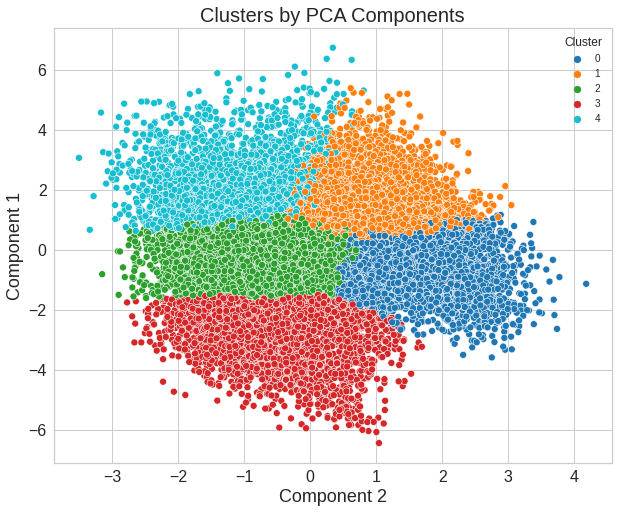

In [276]:
pca2 = nongk_pca_kmeans_df['PCA Component 2']
pca1 = nongk_pca_kmeans_df['PCA Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(pca2, pca1, hue=nongk_pca_kmeans_df['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:cyan'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

3차원 시각화(PCA component가 3개)

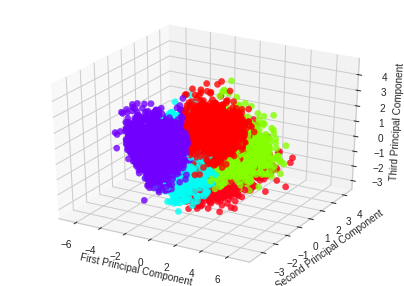

In [277]:
Xax = np.array(nongk_pca_kmeans_df['PCA Component 1'])
Yax = np.array(nongk_pca_kmeans_df['PCA Component 2'])
Zax = np.array(nongk_pca_kmeans_df['PCA Component 3'])
y=labels

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor('white')

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('hsv')
pca_clustered_sctt=ax.scatter(Xax,Yax,Zax,alpha=0.8, marker="o",c=nongk_pca_kmeans_df["Cluster"],s=40,cmap=my_cmap)
ax.set_xlabel("First Principal Component", fontsize=10)
ax.set_ylabel("Second Principal Component", fontsize=10)
ax.set_zlabel("Third Principal Component", fontsize=10)

# fig.colorbar(pca_clustered_sctt, ax = ax, shrink = 0.5, aspect = 5)
ax.legend()
plt.show()

이는 원래 데이터를 활용하여 **radar chart**를 만들면 각 cluster의 결과를 효과적으로 보여줄 수 있다.

In [280]:
nongk_abil=non_gk.iloc[:,39:68]
#능력치 데이터만 가져와본다. cluster와 합치기
non_gk_new = pd.concat([labels_df,nongk_abil.reset_index(drop=True)], axis=1)
non_gk_new
# non_gk_new[non_gk_new.columns.tolist()]

Cluster  Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  \
0            4      84.0       90.0             70.0          91.0     88.0   
1            4      75.0       92.0             90.0          89.0     88.0   
2            4      71.0       94.0             91.0          84.0     89.0   
3            4      94.0       85.0             55.0          93.0     83.0   
4            4      78.0       93.0             72.0          85.0     83.0   
...        ...       ...        ...              ...           ...      ...   
16473        0      40.0       49.0             30.0          42.0     48.0   
16474        3      34.0       33.0             44.0          46.0     31.0   
16475        0      41.0       36.0             42.0          54.0     37.0   
16476        3      21.0       20.0             41.0          25.0     27.0   
16477        3      38.0       28.0             41.0          35.0     29.0   

       Dribbling  Curve  FKAccuracy  LongPassing  ...  LongShots  Aggression  \
0           95.0   93.0        93.0         90.0  ...       91.0        44.0   
1           87.0   82.0        73.0         76.0  ...       80.0        63.0   
2           85.0   79.0        85.0         70.0  ...       84.0        81.0   
3           88.0   89.0        83.0         93.0  ...       91.0        75.0   
4           93.0   80.0        69.0         71.0  ...       82.0        64.0   
...          ...    ...         ...          ...  ...        ...         ...   
16473       50.0   53.0        50.0         33.0  ...       46.0        37.0   
16474       42.0   32.0        31.0         45.0  ...       35.0        52.0   
16475       52.0   47.0        42.0         52.0  ...       36.0        39.0   
16476       27.0   26.0        20.0         22.0  ...       18.0        42.0   
16477       47.0   33.0        32.0         29.0  ...       28.0        47.0   

       Interceptions  Positioning  Vision  Penalties  Composure  Marking  \
0               40.0         93.0    94.0       75.0       96.0     20.0   
1               39.0         92.0    89.0       84.0       90.0     43.0   
2               49.0         94.0    81.0       90.0       88.0     35.0   
3               66.0         88.0    94.0       83.0       89.0     68.0   
4               38.0         92.0    83.0       80.0       88.0     26.0   
...              ...          ...     ...        ...        ...      ...   
16473           22.0         50.0    52.0       40.0       47.0     39.0   
16474           46.0         35.0    40.0       33.0       45.0     46.0   
16475           24.0         42.0    50.0       43.0       59.0     39.0   
16476           54.0         23.0    32.0       37.0       41.0     50.0   
16477           40.0         36.0    39.0       35.0       32.0     47.0   

       StandingTackle  SlidingTackle  
0                35.0           24.0  
1                24.0           18.0  
2                42.0           19.0  
3                65.0           53.0  
4                34.0           32.0  
...               ...            ...  
16473            29.0           27.0  
16474            50.0           52.0  
16475            37.0           48.0  
16476            54.0           54.0  
16477            44.0           43.0  

[16478 rows x 30 columns]

In [282]:
def make_cluster_radar(data,standard_level):  
    attrs=data.columns.drop(standard_level).tolist()
    attrs_data=data[attrs].values
    standard_level=data[standard_level]
    fig, ax = plt.subplots(1, figsize=(10,10), subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1) # 그려지는 방향 시계방향
    angles = np.linspace(0, 2*np.pi, len(attrs), endpoint=False) #radian 기준으로 angle잡음
    angles = np.concatenate((angles,[angles[0]]))
    n_clusters = np.unique(standard_level)
    color=iter(plt.cm.gist_rainbow(np.linspace(0,1,len(n_clusters))))
    ax.set_thetagrids(angles * 180/np.pi, attrs) # 각도에 따른 grid 및 ticklabels 변경
    #Python NumPy의 삼각함수는 radian을 사용하기 때문에 degree 를 radian으로 바꿔주기 위해서 degree * np.py/180 을 해주었습니다. ( np.deg2rad(x) 함수를 사용해도 됨 )
    ax.grid(True)
    #standard level list에 있는 값들
    #여기까지가 큰틀이고 이제부터 cluster에 적용
    n_clusters = np.unique(standard_level)
    my_palette = plt.cm.get_cmap("rainbow", len(n_clusters))
    for i,cluster in enumerate(n_clusters):
      c = next(color)
      cluster_indexes=np.where(cluster==standard_level) # 클러스터마다 i번째 해당하는 거 싹다 index모아버린다.
      abilities=np.mean(attrs_data[cluster_indexes],axis=0)
      abilities = np.concatenate((abilities, [abilities[0]]))
      ax.plot(angles, abilities,color=c,linewidth=1, linestyle='solid', label='cluster {}'.format(cluster)) ## 레이더 차트 출력
      ax.fill(angles, abilities, c,alpha=0.1) ## 도형 안쪽에 색을 채워준다.
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,0.9))

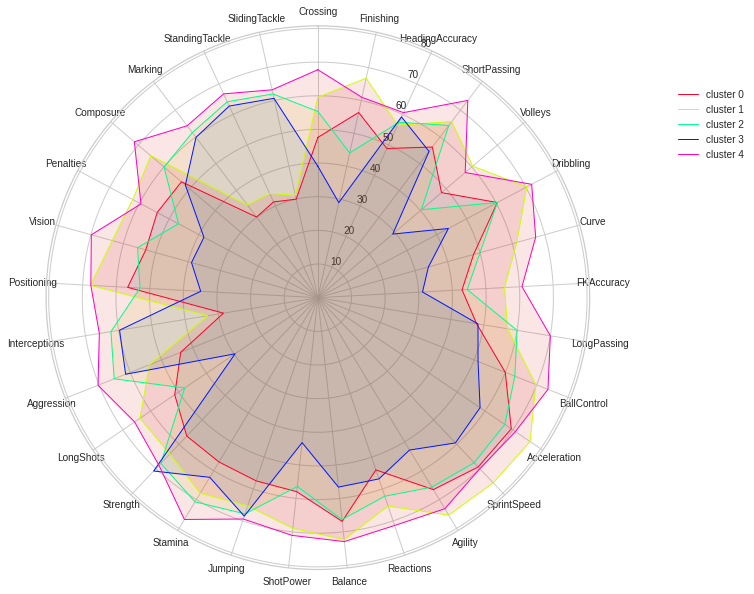

In [283]:
make_cluster_radar(non_gk_new,'Cluster')

**이 radar chart를 통해 어떻게 군집이 된 것인지 추측해볼 수 있다.**

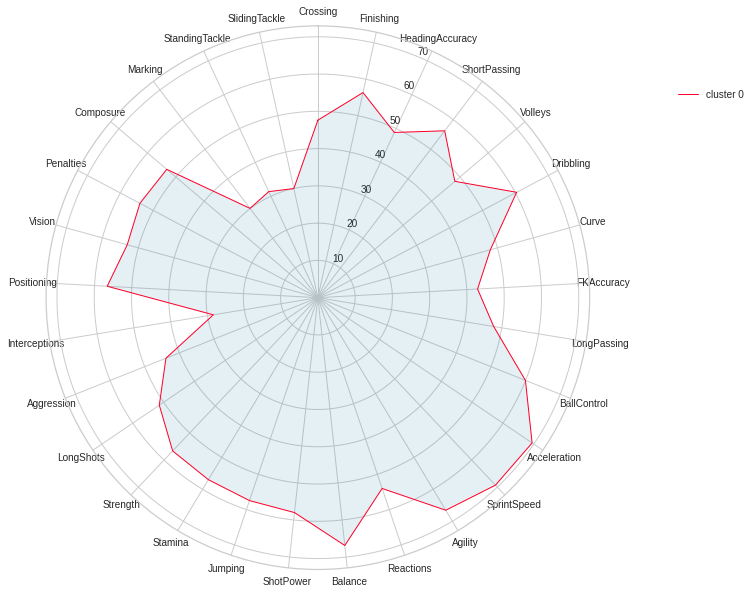

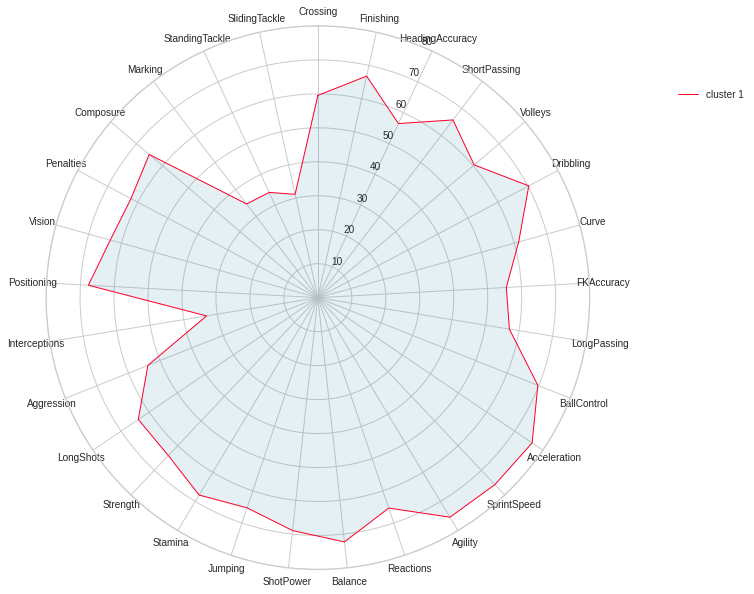

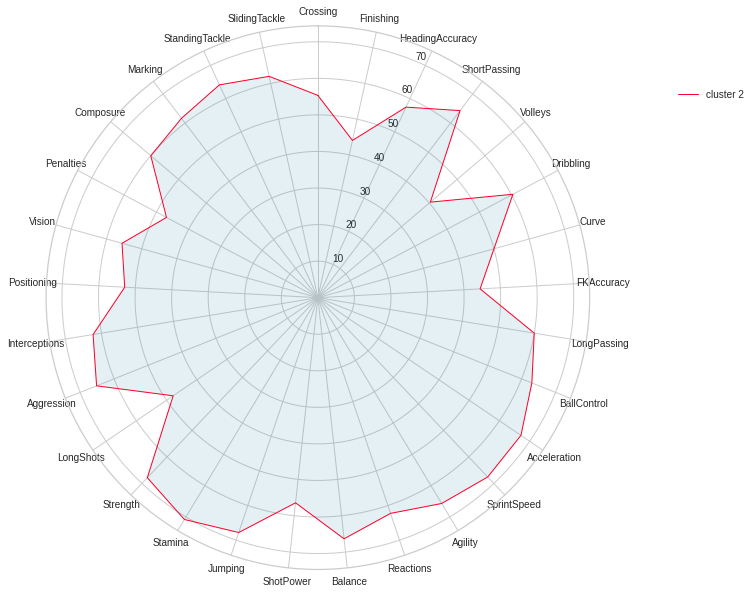

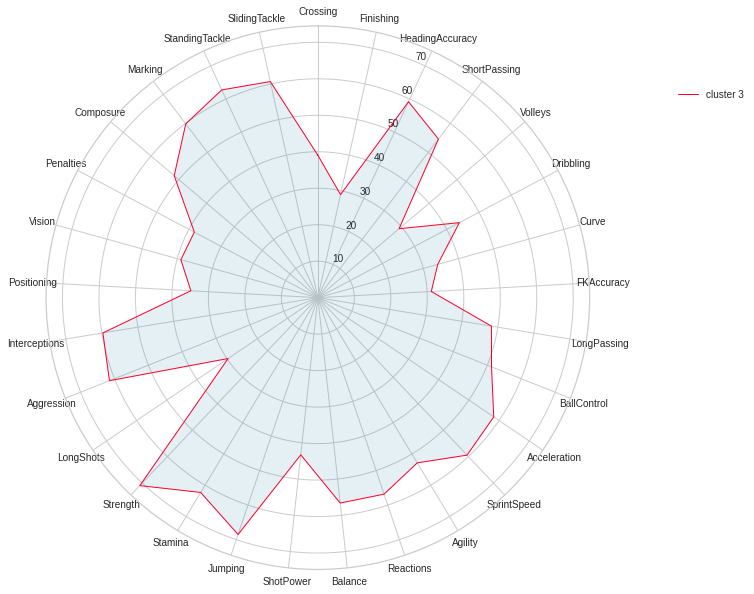

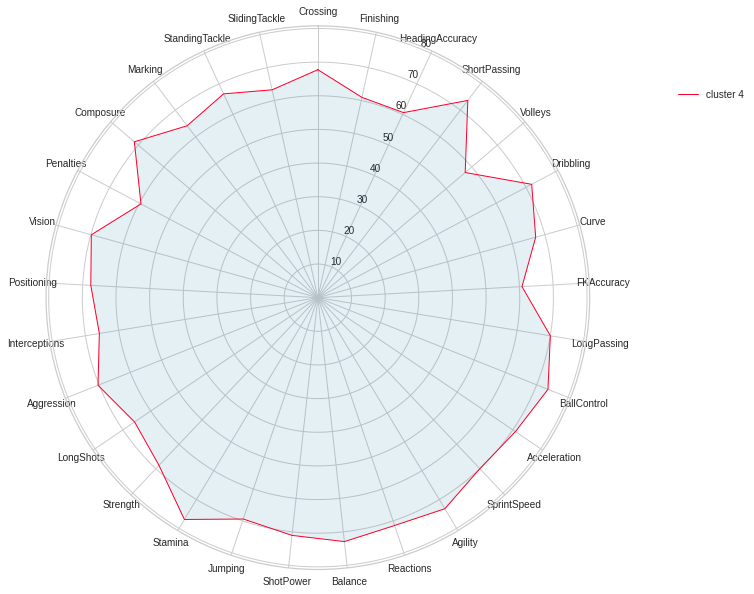

In [284]:
for i in range(5):
  make_cluster_radar(non_gk_new[non_gk_new.Cluster==i], 'Cluster')

## **Find similar player using radar chart and cosine similarity (usefulness of my app)**

In [285]:
# son=nongk_pca_kmeans_df[nongk_pca_kmeans_df['Name']=='H. Son']
# son.values[0,-4:]

개별적인 선수의 radar chart를 만들어주는 **make_player_radar** 함수

In [286]:
def make_player_radar(data,standard_level):  
    attrs=data.columns.drop(standard_level).tolist()
    attrs_data=data[attrs].values
    standard_level=data[standard_level]
    fig, ax = plt.subplots(1, figsize=(10,10), subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1) # 그려지는 방향 시계방향
    angles = np.linspace(0, 2*np.pi, len(attrs), endpoint=False) #radian 기준으로 angle잡음
    angles = np.concatenate((angles,[angles[0]]))
    
    ax.set_thetagrids(angles * 180/np.pi, attrs) # 각도에 따른 grid 및 ticklabels 변경
    #Python NumPy의 삼각함수는 radian을 사용하기 때문에 degree 를 radian으로 바꿔주기 위해서 degree * np.py/180 을 해주었습니다. ( np.deg2rad(x) 함수를 사용해도 됨 )
    ax.grid(True)
    #standard level list에 있는 값들
    #여기까지가 큰틀이고 이제부터 cluster에 적용
    n_players = np.unique(standard_level) # 손흥민만 이씅니까 1
    my_palette = plt.cm.get_cmap("rainbow", len(n_players))
    for i,player in enumerate(n_players):
      color = my_palette(i)
      abilities=attrs_data[i]
      abilities = np.concatenate((abilities, [abilities[0]]))
      ax.plot(angles, abilities,color=color,linewidth=1, linestyle='solid', label='{}'.format(player)) ## 레이더 차트 출력
      ax.fill(angles, abilities, color=color,alpha=0.1) ## 도형 안쪽에 색을 채워준다.
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,0.9))

In [287]:
# make_player_radar(name_abil[name_abil.FullName==player_name],'FullName')
# non_gk_new[non_gk_new.Cluster==i]

 ipywidgets는 UI 라이브러리로 함수를 전달하면 셀렉트 박스나 슬라이더의 조작으로 인수를 변경하면서 함수 실행 가능

이를 통해 선수를 검색해 볼 수 있다.

In [288]:
from pandas._config import describe_option
import ipywidgets as widgets
from ipywidgets import interactive

def view():
    global widg
    items = sorted(non_gk['FullName'].unique().tolist())
    widg=widgets.Select(options=items,description="Player name: ")
    display(widg)
    return widg

interactive(view)


# print(player_name.value)


interactive(children=(Output(),), _dom_classes=('widget-interact',))

**비슷한 선수를 검색하고 싶을 때마다 이 텍스트 이후 셀 실행한 뒤에 선수 이름 검색 하면 됩니다.**

Input name of the player : Harry Kane


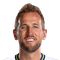

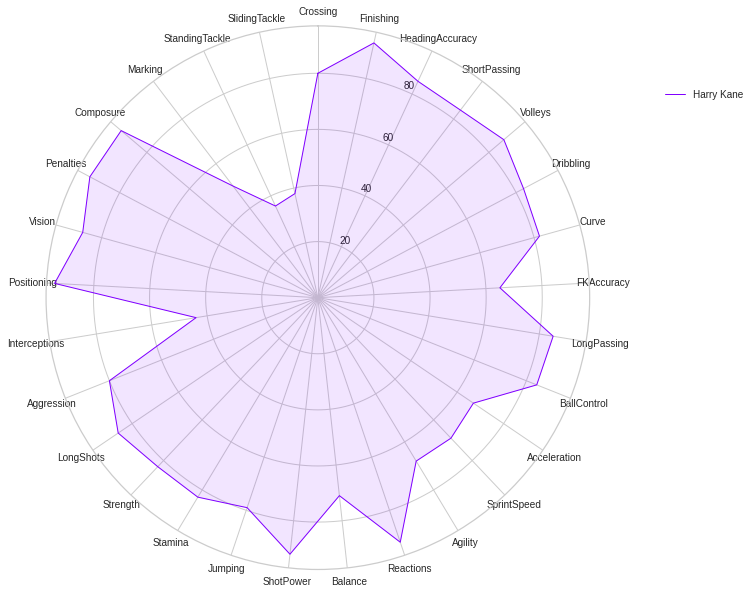

In [298]:
# 선수를 입력하세요 (csv 파일에 있는 FullName 그대로 입력해야 함, 철자 및 띄어쓰기 주의, 영어 외 문자는 그냥 복사해 올 것)
player_name=input("Input name of the player : ")

def player_show(df,player_name):
  player_df=df[df['FullName']==player_name]
  url=player_df.iloc[0,6]
  im = Image.open(requests.get(url, stream=True).raw)
  full_name=df.iloc[:,2]
  nongk_abil=df.iloc[:,39:68]
  name_abil= pd.concat([full_name,nongk_abil.reset_index(drop=True)], axis=1)
  selected_player_radar=make_player_radar(name_abil[name_abil.FullName==player_name],'FullName')
  return im
player_show(non_gk,player_name)


In [299]:
def SimilarityDistances(df,selected_player,func):
  return_list={}
  similarity_list={}
  selected_player_vec=df[df['FullName']==selected_player].values[0,-4:]
  #선택된 선수의 pca value만 긁어옴
  #values는 array 2차원 형태로 반환됨
  for idx,row in df.iterrows():
    player_name=row['FullName']
    # 같은 클러스터에 이름이 다른 이름이면
    if row['Cluster']==df[df['FullName']==selected_player].values[0,1] and player_name!=selected_player:
      compared_player_vec=[row['PCA Component 1'],row['PCA Component 2'],row['PCA Component 3'],row['PCA Component 4']]
      similarity_list[player_name]=float(sim.cosine_similarity([selected_player_vec],[compared_player_vec])[0])
      # 비슷한 선수마다 simliarity를 기록
  #10개정도 혹은 그보다 적은 수의 표본
  n=10
  similarity_list=OrderedDict(sorted(similarity_list.items(), key=lambda x: x[1], reverse=True))
  idx=0
  for key,value in similarity_list.items():
    if idx<n:
      return_list[key]='{0:0.5f}'.format(value)
      idx+=1
    else:
      break
  return return_list

In [300]:
Similar_10players=SimilarityDistances(nongk_pca_kmeans_ordered_df,player_name,'cosine')
Similar_10players=pd.DataFrame.from_dict(Similar_10players,orient='index', columns=['Similarity'])
Similar_10players=Similar_10players.rename_axis('FullName').reset_index()

In [301]:
Similar_10players

FullName Similarity
0  Franko Andrijašević    0.99926
1          Luis Suárez    0.99874
2        Kevin Volland    0.99786
3  Alexandre Lacazette    0.99585
4          Nick Powell    0.99396
5         Raúl Jiménez    0.99385
6   Michael Folorunsho    0.99168
7        Florin Andone    0.99127
8  Adrian Mierzejewski    0.99034
9           Danny Ings    0.98985

In [303]:
# non_gk_fullname = pd.concat([labels_df,nongk_abil.reset_index(drop=True)], axis=1)
# non_gk_fullname

[[84. 90. 70. ... 20. 35. 24.]
 [75. 92. 90. ... 43. 24. 18.]
 [71. 94. 91. ... 35. 42. 19.]
 ...
 [41. 36. 42. ... 39. 37. 48.]
 [21. 20. 41. ... 50. 54. 54.]
 [38. 28. 41. ... 47. 44. 43.]]


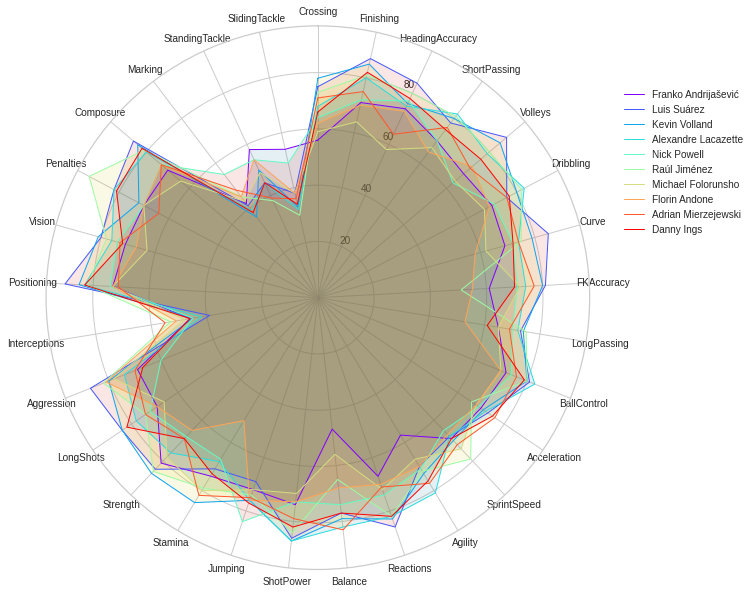

In [304]:
def make_similar_radar(df,sim_data,standard_level):  
    full_name=df.iloc[:,2]
    nongk_abil=df.iloc[:,39:68]
    name_abil= pd.concat([full_name,nongk_abil.reset_index(drop=True)], axis=1)
    attrs=name_abil.columns.drop(standard_level).tolist()
    attrs_data=df[attrs].values
    # standard_level=df[standard_level] #fullname만 있음
    fig, ax = plt.subplots(1, figsize=(10,10), subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1) # 그려지는 방향 시계방향
    angles = np.linspace(0, 2*np.pi, len(attrs), endpoint=False) #radian 기준으로 angle잡음
    angles = np.concatenate((angles,[angles[0]]))
    n_players= len(sim_data)
    color=iter(plt.cm.gist_rainbow(np.linspace(0,1,n_players)))
    ax.set_thetagrids(angles * 180/np.pi, attrs) # 각도에 따른 grid 및 ticklabels 변경
    #Python NumPy의 삼각함수는 radian을 사용하기 때문에 degree 를 radian으로 바꿔주기 위해서 degree * np.py/180 을 해주었습니다. ( np.deg2rad(x) 함수를 사용해도 됨 )
    ax.grid(True)
    #standard level list에 있는 값들
    #여기까지가 큰틀이고 이제부터 cluster에 적용
    my_palette = plt.cm.get_cmap("rainbow", n_players)
    for i in range(n_players):
      c= my_palette(i)
      index=np.where(name_abil['FullName']==sim_data.iloc[i,0])
      abilities=attrs_data[index]
      # abilities=attrs_data[i]
      #  cluster_indexes=np.where(cluster==standard_level) # 클러스터마다 i번째 해당하는 거 싹다 index모아버려
      # abilities=np.mean(attrs_data[cluster_indexes],axis=0)
      # abilities = np.concatenate((abilities, [abilities[0]]))
      abilities = np.concatenate([abilities[0], [abilities[0][0]]])
      ax.plot(angles, abilities,color=c,linewidth=1, linestyle='solid', label='{}'.format(sim_data.iloc[i,0])) ## 레이더 차트 출력
      ax.fill(angles, abilities,c,alpha=0.1) ## 도형 안쪽에 색을 채워준다.
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,0.9))
make_similar_radar(non_gk,Similar_10players,'FullName')

similar 한 선수들 index를 활용하여 원래 선수와 similar한 선수 radar차트 그려보자 radar function은 그대로

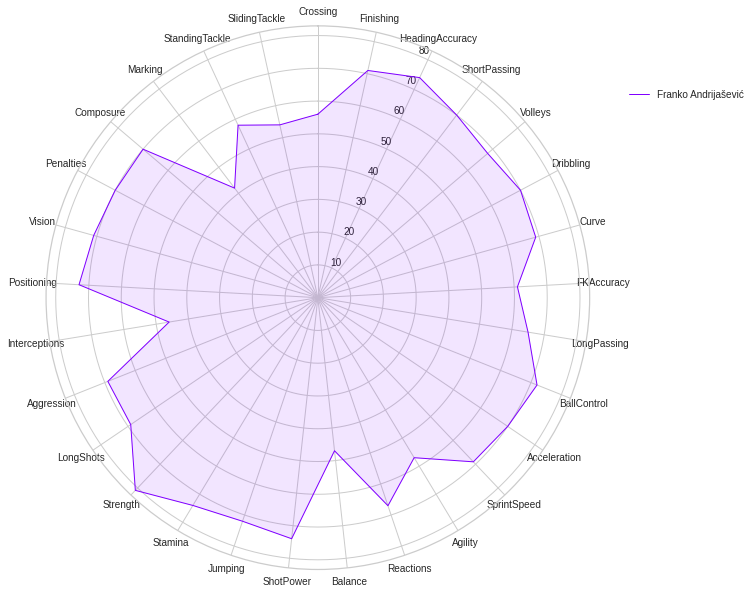

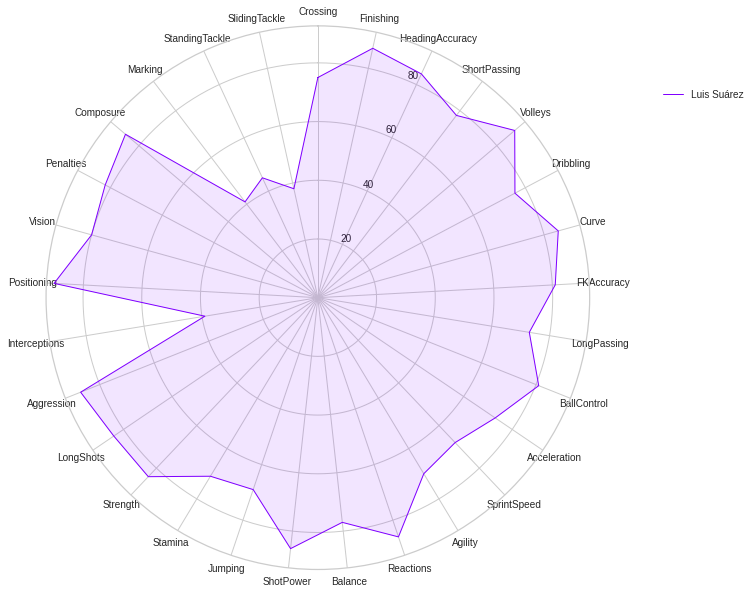

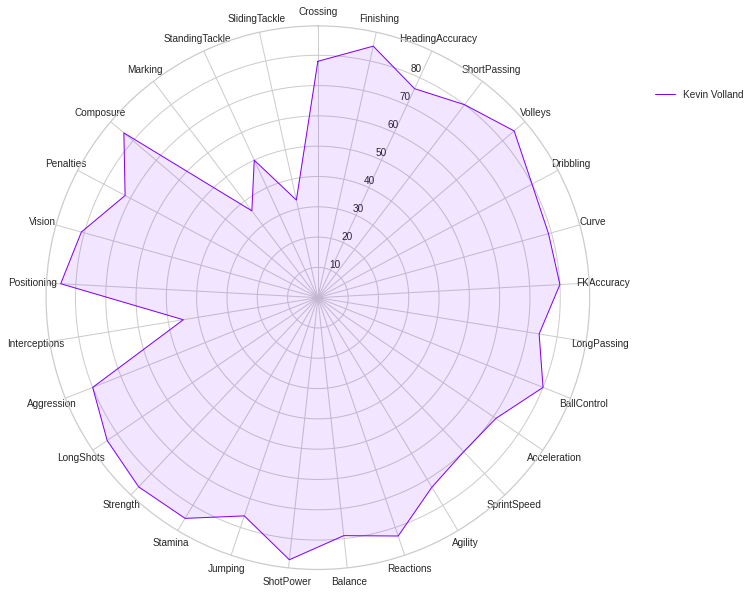

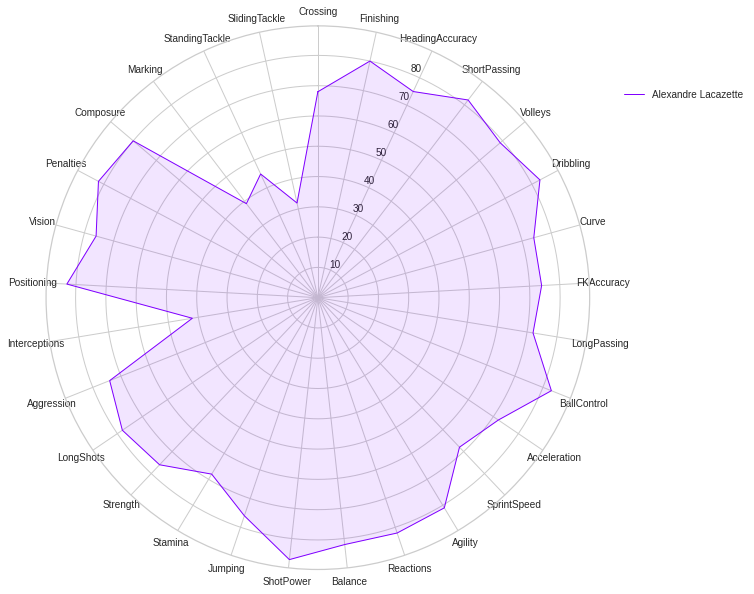

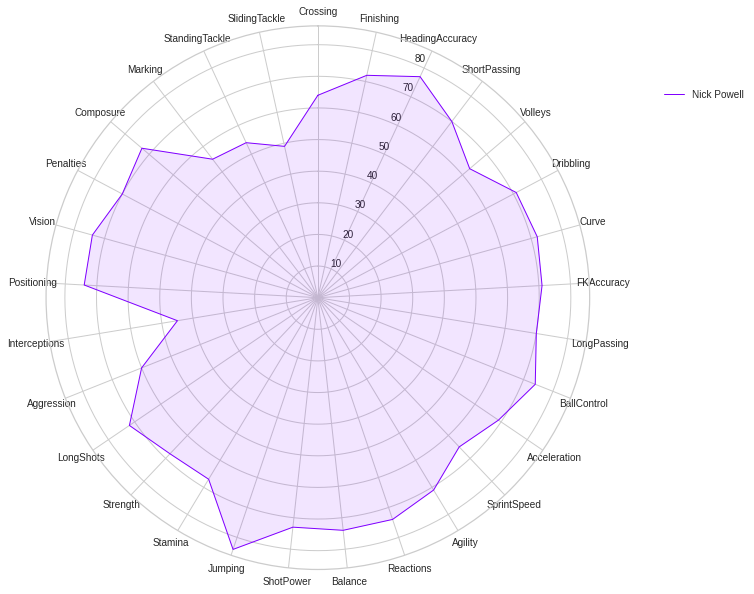

In [305]:
def simplayer_show(df,Sim_players):
  simplayer_name=Sim_players.iloc[i,0]
  player_df=df[df['FullName']==simplayer_name]
  url=player_df.iloc[0,6]
  im = Image.open(requests.get(url, stream=True).raw)
  full_name=df.iloc[:,2]
  nongk_abil=df.iloc[:,39:68]
  name_abil= pd.concat([full_name,nongk_abil.reset_index(drop=True)], axis=1)
  im.show()
  selected_player_radar=make_player_radar(name_abil[name_abil.FullName==simplayer_name],'FullName')
  return im
#5개만 보여주자..

for i in range(5):
  simplayer_show(non_gk,Similar_10players)